In [1]:
!pip install ucimlrepo
!pip install numpy tslearn scikit-learn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 389.9/389.9 kB 10.1 MB/s eta 0:00:00


##Improt

In [2]:
from ucimlrepo import fetch_ucirepo
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
from sklearn.preprocessing import MinMaxScaler
import numpy as np
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score, calinski_harabasz_score
from scipy.spatial import distance
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.cluster import AgglomerativeClustering, kmeans_plusplus, MiniBatchKMeans
import sklearn
from sklearn.mixture import GaussianMixture
from sklearn.cluster import DBSCAN

##Load data

In [3]:
# fetch dataset
individual_household_electric_power_consumption = fetch_ucirepo(id=235)

# data (as pandas dataframes)
X = individual_household_electric_power_consumption.data.features
y = individual_household_electric_power_consumption.data.targets

# Convert relevant columns to numeric, coercing errors
numeric_cols = ['Global_active_power', 'Global_reactive_power', 'Voltage', 'Global_intensity', 'Sub_metering_1', 'Sub_metering_2', 'Sub_metering_3']
for col in numeric_cols:
    X[col] = pd.to_numeric(X[col], errors='coerce')

# metadata
print(individual_household_electric_power_consumption.metadata)

# variable information
print(individual_household_electric_power_consumption.variables)

/usr/local/lib/python3.12/dist-packages/ucimlrepo/fetch.py:97: DtypeWarning: Columns (2,3,4,5,6,7) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(data_url)


{'uci_id': 235, 'name': 'Individual Household Electric Power Consumption', 'repository_url': 'https://archive.ics.uci.edu/dataset/235/individual+household+electric+power+consumption', 'data_url': 'https://archive.ics.uci.edu/static/public/235/data.csv', 'abstract': 'Measurements of electric power consumption in one household with a one-minute sampling rate over a period of almost 4 years. Different electrical quantities and some sub-metering values are available.', 'area': 'Physics and Chemistry', 'tasks': ['Regression', 'Clustering'], 'characteristics': ['Multivariate', 'Time-Series'], 'num_instances': 2075259, 'num_features': 9, 'feature_types': ['Real'], 'demographics': [], 'target_col': None, 'index_col': None, 'has_missing_values': 'no', 'missing_values_symbol': None, 'year_of_dataset_creation': 2006, 'last_updated': 'Fri Mar 08 2024', 'dataset_doi': '10.24432/C58K54', 'creators': ['Georges Hebrail', 'Alice Berard'], 'intro_paper': None, 'additional_info': {'summary': 'This archiv

In [61]:
X = X.drop('Voltage', axis=1)
X = X.dropna().reset_index(drop=True) #dropping any row that contains Nan
X

,Date,Time,Global_active_power,Global_reactive_power,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
0,16/12/2006,17:24:00,4.216,0.418,18.4,0.0,1.0,17.0
1,16/12/2006,17:25:00,5.360,0.436,23.0,0.0,1.0,16.0
2,16/12/2006,17:26:00,5.374,0.498,23.0,0.0,2.0,17.0
3,16/12/2006,17:27:00,5.388,0.502,23.0,0.0,1.0,17.0
4,16/12/2006,17:28:00,3.666,0.528,15.8,0.0,1.0,17.0
...,...,...,...,...,...,...,...,...
2049275,26/11/2010,20:58:00,0.946,0.000,4.0,0.0,0.0,0.0
2049276,26/11/2010,20:59:00,0.944,0.000,4.0,0.0,0.0,0.0
2049277,26/11/2010,21:00:00,0.938,0.000,3.8,0.0,0.0,0.0
2049278,26/11/2010,21:01:00,0.934,0.000,3.8,0.0,0.0,0.0


In [62]:
#Normalizing the data with min-max:

X_scaled = X.copy()
scaler_per_feature = MinMaxScaler()
numeric_cols = ['Global_active_power', 'Global_reactive_power', 'Global_intensity', 'Sub_metering_1', 'Sub_metering_2', 'Sub_metering_3'] #'Voltage'
submeter = numeric_cols[-3:]
for col in numeric_cols:
    X_scaled[col] = scaler_per_feature.fit_transform(X_scaled[[col]])


##Feature Extraction

In [63]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.cluster import KMeans
from numpy.fft import fft

feature_vectors = []
#Group by 'Date' to process each day:
grouped_days = X.groupby('Date')
grouped_days_scaled = X_scaled.groupby('Date')

for date, day_data_raw in grouped_days:

    day_data_scaled = grouped_days_scaled.get_group(date)

    day_means = day_data_scaled[numeric_cols].mean().values
    day_peak_magnitudes = day_data_scaled[numeric_cols].max().values
    day_variances = day_data_scaled[numeric_cols].var().values

    peak_time_features = []

    for feature in numeric_cols:

        peak_index = day_data_scaled[feature].values.argmax()
        current_day_length = len(day_data_scaled)
        normalized_time = peak_index / current_day_length
        peak_time_features.extend([
            np.sin(2 * np.pi * normalized_time),
            np.cos(2 * np.pi * normalized_time)
        ])

    peak_time_features = np.array(peak_time_features)

    submeter_totals = day_data_raw[submeter].sum().values
    total_submeter_sum = np.sum(submeter_totals)
    submeter_ratios = submeter_totals / total_submeter_sum if total_submeter_sum != 0 else np.zeros(3)


    power_signal = day_data_raw[numeric_cols[0]].values
    fourier_coeffs = fft(power_signal)
    fourier_magnitudes = np.abs(fourier_coeffs[1:5])


    day_vector = np.concatenate([
        day_means,
        day_peak_magnitudes,
        day_variances,
        peak_time_features,
        submeter_ratios,
        fourier_magnitudes
    ])

    feature_vectors.append(day_vector)


X_features = np.array(feature_vectors)

print(f"Final Feature Matrix shape: {X_features.shape}")
print(f"Number of features per day: {X_features.shape[1]} (42 total)")
print("-" * 50)

#final standardizing
scaler_final = StandardScaler()
X_scaled_features = scaler_final.fit_transform(X_features)


Final Feature Matrix shape: (1433, 37)
Number of features per day: 37 (42 total)
--------------------------------------------------


##KMEANS

In [69]:
# Find the best number of clusters using the silhouette score
data = X_scaled_features
K = [2, 3, 4, 5, 6, 7]
silhouette_avg = []
for k in K:
    k_means = KMeans(n_clusters=k, n_init=10, random_state=42)
    k_means.fit(data)
    silhouette_avg.append(silhouette_score(data, k_means.labels_))

k_best = K[np.where(silhouette_avg == np.max(silhouette_avg))[0][0]]


K-Means Cluster Population Distribution:


,Sunday,Monday,Tuesday,Wednesday,Thursday,Friday,Saturday
0,59.0,55.0,59.0,52.0,59.0,49.0,55.0
1,37.0,24.0,27.0,27.0,25.0,26.0,23.0
2,51.0,54.0,55.0,70.0,61.0,60.0,59.0
3,58.0,72.0,64.0,56.0,60.0,69.0,67.0


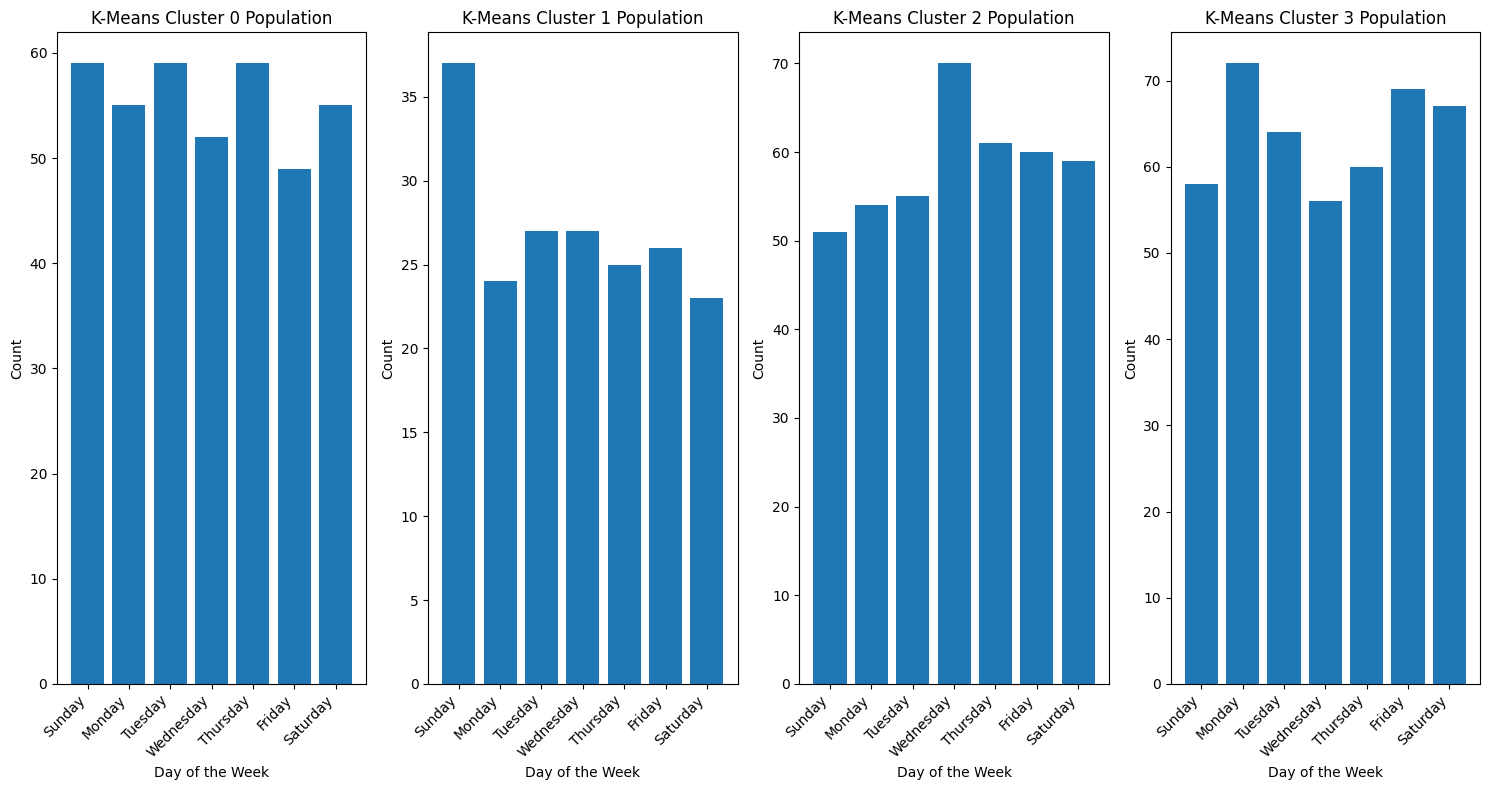

In [70]:
data = X_scaled_features
k_best = 4

# Fit K-Means with the best number of clusters
k_means = KMeans(n_clusters=k_best, n_init=10, random_state=42)
k_means.fit(data)
kmeans_labels = k_means.labels_


data_ = data

tsne = TSNE(n_components=3, init='pca', random_state=0)
X_tsne = tsne.fit_transform(data_)

# Create a DataFrame for Plotly
tsne_df = pd.DataFrame(X_tsne, columns=['Dimension 1', 'Dimension 2', 'Dimension 3'])
tsne_df['Cluster'] = kmeans_labels.astype(str)

# Create 3D scatter plot
fig = px.scatter_3d(tsne_df, x='Dimension 1', y='Dimension 2', z='Dimension 3',
                    color='Cluster', title=f'3D t-SNE visualization of K-Means clusters (k={k_best})', size_max=3)
fig.show()

# Analyze cluster populations by day of the week
day_label = ['Sunday', 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday']
kmeans_population = np.zeros((k_best, 7))
for i in range(data.shape[0]):
    kmeans_population[kmeans_labels[i], i % 7] += 1

kmeans_population_df = pd.DataFrame(kmeans_population, columns=day_label)

print("\nK-Means Cluster Population Distribution:")
display(kmeans_population_df)

# Plot the population distribution
plt.figure(figsize=(15, max(5, k_best * 2)))
for i in range(kmeans_population_df.shape[0]):
    plt.subplot(max(1, (k_best + 3) // 4), 4, i + 1)
    plt.bar(kmeans_population_df.columns, kmeans_population_df.iloc[i, :])
    plt.title(f'K-Means Cluster {i} Population')
    plt.xlabel('Day of the Week')
    plt.ylabel('Count')
    plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

##HAC


HAC Cluster Population Distribution:


,Sunday,Monday,Tuesday,Wednesday,Thursday,Friday,Saturday
0,71.0,72.0,69.0,84.0,84.0,71.0,73.0
1,65.0,74.0,65.0,58.0,58.0,74.0,67.0
2,40.0,39.0,47.0,39.0,38.0,38.0,41.0
3,29.0,20.0,24.0,24.0,25.0,21.0,23.0


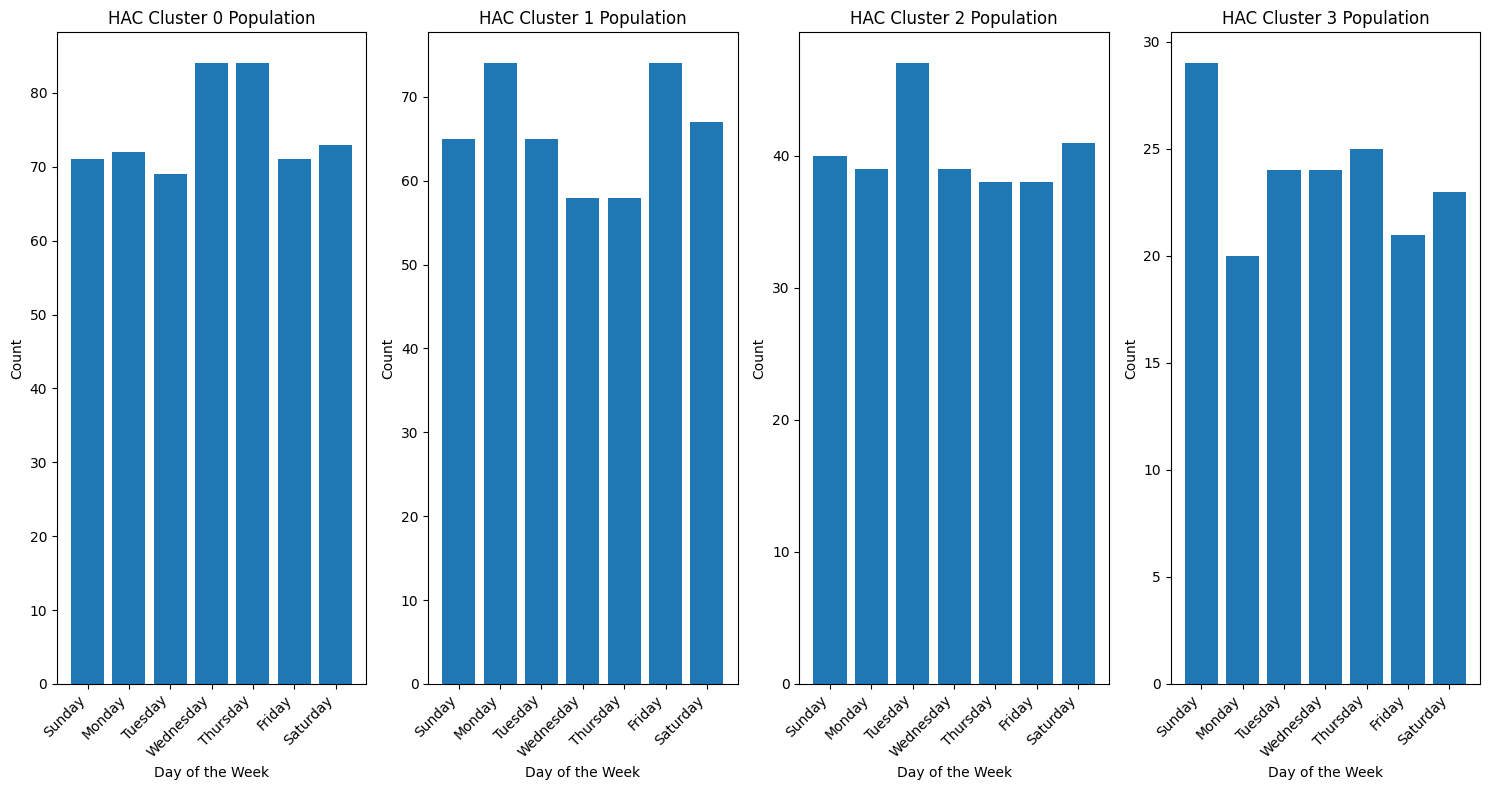

In [65]:
data = X_scaled_features
n_clusters = 4

# Perform Hierarchical Agglomerative Clustering
hac = AgglomerativeClustering(n_clusters=n_clusters, linkage='ward')
hac_labels = hac.fit_predict(data)


data_ = data

tsne = TSNE(n_components=3, init='pca', random_state=0)
X_tsne = tsne.fit_transform(data_)

# Create a DataFrame for Plotly
tsne_df = pd.DataFrame(X_tsne, columns=['Dimension 1', 'Dimension 2', 'Dimension 3'])
tsne_df['Cluster'] = hac_labels.astype(str)

# Create 3D scatter plot
fig = px.scatter_3d(tsne_df, x='Dimension 1', y='Dimension 2', z='Dimension 3',
                    color='Cluster', title=f'3D t-SNE visualization of HAC clusters (n_clusters={n_clusters})', opacity=0.7, size_max=5)
fig.show()

# Analyze cluster populations by day of the week
day_label = ['Sunday', 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday']
hac_population = np.zeros((n_clusters, 7))
for i in range(data.shape[0]):
    hac_population[hac_labels[i], i % 7] += 1

hac_population_df = pd.DataFrame(hac_population, columns=day_label)

print("\nHAC Cluster Population Distribution:")
display(hac_population_df)

# Plot the population distribution
plt.figure(figsize=(15, max(5, n_clusters * 2)))
for i in range(hac_population_df.shape[0]):
    plt.subplot(max(1, (n_clusters + 3) // 4), 4, i + 1)
    plt.bar(hac_population_df.columns, hac_population_df.iloc[i, :])
    plt.title(f'HAC Cluster {i} Population')
    plt.xlabel('Day of the Week')
    plt.ylabel('Count')
    plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

##Plot the features' mean per cluster

In [66]:
# Group the original data by day and calculate the mean for each day
X_daily_mean = X_scaled.groupby('Date')[numeric_cols].mean().reset_index()

# Add cluster labels to the daily mean dataframe
X_daily_mean['KMeans_Cluster'] = kmeans_labels
X_daily_mean['HAC_Cluster'] = hac_labels

# Calculate and display mean values per cluster for K-Means
print("K-Means Cluster Mean Original Feature Values:")
kmeans_mean_original_features = X_daily_mean.groupby('KMeans_Cluster')[numeric_cols].mean()
display(kmeans_mean_original_features)

# Calculate and display mean values per cluster for HAC
print("\nHAC Cluster Mean Original Feature Values:")
hac_mean_original_features = X_daily_mean.groupby('HAC_Cluster')[numeric_cols].mean()
display(hac_mean_original_features)

# Reshape the data for plotting
kmeans_plot_data = kmeans_mean_original_features.reset_index().melt('KMeans_Cluster', var_name='Feature', value_name='Mean Value')
hac_plot_data = hac_mean_original_features.reset_index().melt('HAC_Cluster', var_name='Feature', value_name='Mean Value')

# Plot the mean original feature values for each K-Means cluster as a grouped bar plot
fig_kmeans_bar = px.bar(kmeans_plot_data, x='KMeans_Cluster', y='Mean Value', color='Feature',
                        barmode='group', title='Mean Value of Original Features per K-Means Cluster',
                        labels={'KMeans_Cluster': 'Cluster'})
fig_kmeans_bar.update_layout(xaxis = dict(tickmode = 'linear', tick0 = 0, dtick = 1))
fig_kmeans_bar.show()

# Plot the mean original feature values for each HAC cluster as a grouped bar plot
fig_hac_bar = px.bar(hac_plot_data, x='HAC_Cluster', y='Mean Value', color='Feature',
                     barmode='group', title='Mean Value of Original Features per HAC Cluster',
                     labels={'HAC_Cluster': 'Cluster'})
fig_hac_bar.update_layout(xaxis = dict(tickmode = 'linear', tick0 = 0, dtick = 1))
fig_hac_bar.show()

K-Means Cluster Mean Original Feature Values:


,Global_active_power,Global_reactive_power,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
KMeans_Cluster,,,,,,
0,0.127460,0.095663,0.126013,0.021719,0.039161,0.245448
1,0.037835,0.086069,0.040358,0.000510,0.005619,0.092618
2,0.091334,0.092497,0.091331,0.014965,0.008974,0.218784
3,0.084663,0.081475,0.084597,0.008140,0.007457,0.213999



HAC Cluster Mean Original Feature Values:


,Global_active_power,Global_reactive_power,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
HAC_Cluster,,,,,,
0,0.096813,0.094051,0.096621,0.016954,0.013474,0.219868
1,0.083759,0.083430,0.083820,0.008958,0.007254,0.208066
2,0.129117,0.090548,0.127463,0.018652,0.042749,0.252857
3,0.036494,0.086553,0.039050,0.000093,0.004830,0.093066


##Using PCA on extracted Features

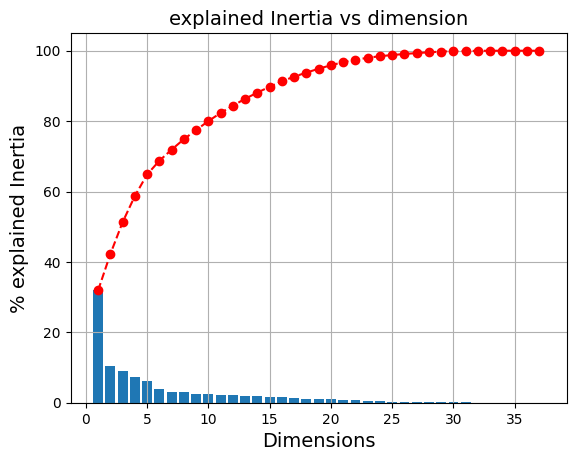

In [71]:
data = X_scaled_features
acp = PCA()

data_ = data
acp.fit(data)
X_pca = acp.transform(data_)
del data_

plt.bar(np.arange(len(acp.explained_variance_ratio_))+1,acp.explained_variance_ratio_*100)
plt.plot(np.arange(len(acp.explained_variance_ratio_))+1,np.cumsum(acp.explained_variance_ratio_*100),'r--o')
plt.xlabel("Dimensions",fontsize=14)
plt.ylabel("% explained Inertia",fontsize=14)
plt.title("explained Inertia vs dimension",fontsize=14);
plt.grid(True)

In [73]:
data = X_scaled_features
pca = PCA(n_components=15)
X_pca = pca.fit_transform(data)

###K-Means


K-Means Cluster Population Distribution:


,Sunday,Monday,Tuesday,Wednesday,Thursday,Friday,Saturday
0,58.0,72.0,63.0,56.0,60.0,69.0,66.0
1,52.0,54.0,55.0,70.0,61.0,60.0,60.0
2,58.0,55.0,59.0,52.0,59.0,49.0,55.0
3,37.0,24.0,28.0,27.0,25.0,26.0,23.0


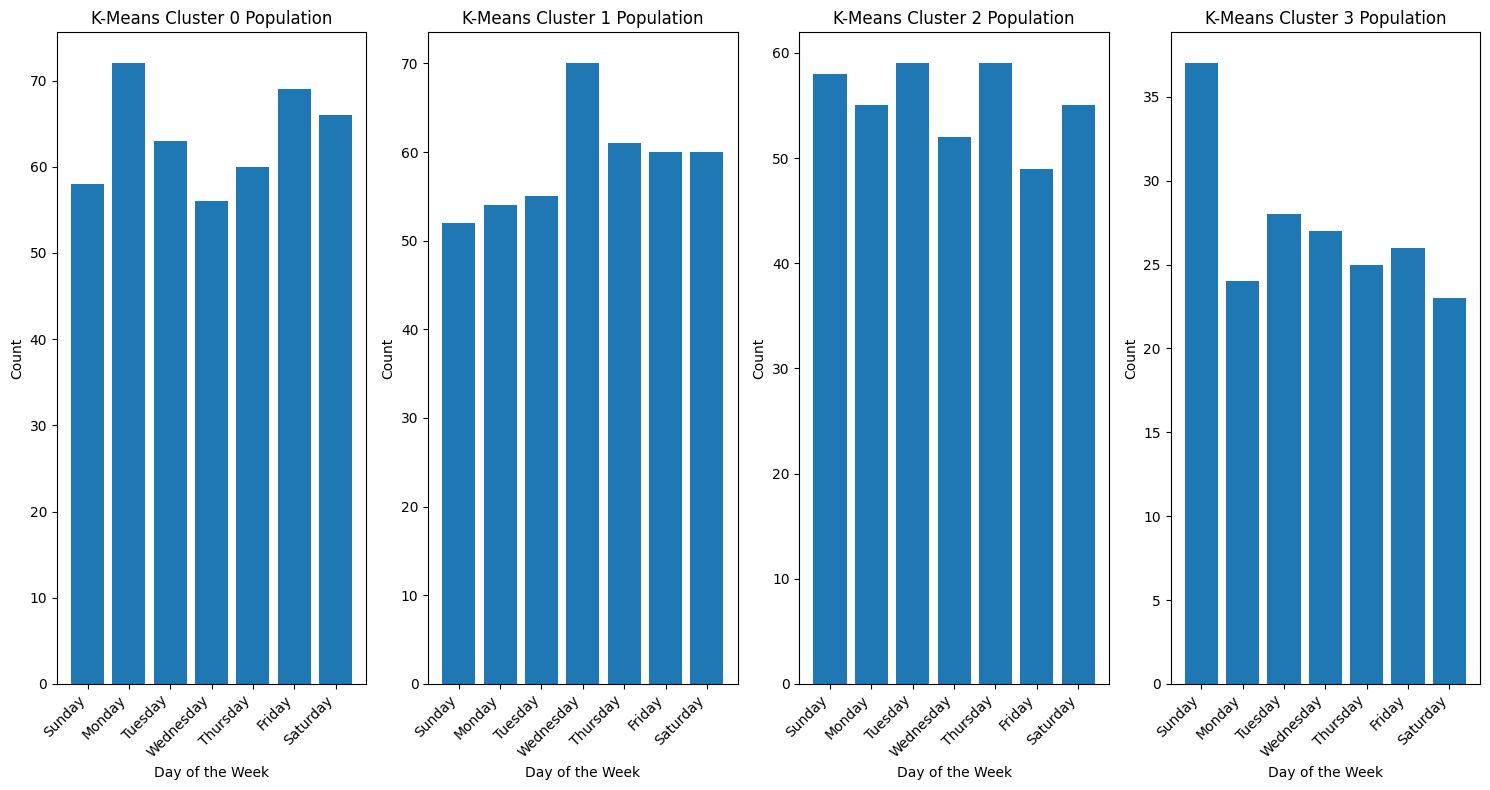

In [74]:
k_best = 4

# Fit K-Means with the best number of clusters
data = X_pca
k_means = KMeans(n_clusters=k_best, n_init=10, random_state=42)
k_means.fit(data)
kmeans_labels = k_means.labels_


data_ = data

tsne = TSNE(n_components=3, init='pca', random_state=0)
X_tsne = tsne.fit_transform(data_)

# Create a DataFrame for Plotly
tsne_df = pd.DataFrame(X_tsne, columns=['Dimension 1', 'Dimension 2', 'Dimension 3'])
tsne_df['Cluster'] = kmeans_labels.astype(str)

# Create 3D scatter plot
fig = px.scatter_3d(tsne_df, x='Dimension 1', y='Dimension 2', z='Dimension 3',
                    color='Cluster', title=f'3D t-SNE visualization of K-Means clusters (k={k_best})', size_max=3)
fig.show()

# Analyze cluster populations by day of the week
day_label = ['Sunday', 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday']
kmeans_population = np.zeros((k_best, 7))
for i in range(data.shape[0]):
    kmeans_population[kmeans_labels[i], i % 7] += 1

kmeans_population_df = pd.DataFrame(kmeans_population, columns=day_label)

print("\nK-Means Cluster Population Distribution:")
display(kmeans_population_df)

# Plot the population distribution
plt.figure(figsize=(15, max(5, k_best * 2)))
for i in range(kmeans_population_df.shape[0]):
    plt.subplot(max(1, (k_best + 3) // 4), 4, i + 1)
    plt.bar(kmeans_population_df.columns, kmeans_population_df.iloc[i, :])
    plt.title(f'K-Means Cluster {i} Population')
    plt.xlabel('Day of the Week')
    plt.ylabel('Count')
    plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


HAC Cluster Population Distribution:


,Sunday,Monday,Tuesday,Wednesday,Thursday,Friday,Saturday
0,83.0,84.0,87.0,71.0,82.0,77.0,86.0
1,49.0,53.0,50.0,69.0,65.0,56.0,56.0
2,24.0,18.0,20.0,22.0,16.0,17.0,16.0
3,49.0,50.0,48.0,43.0,42.0,54.0,46.0


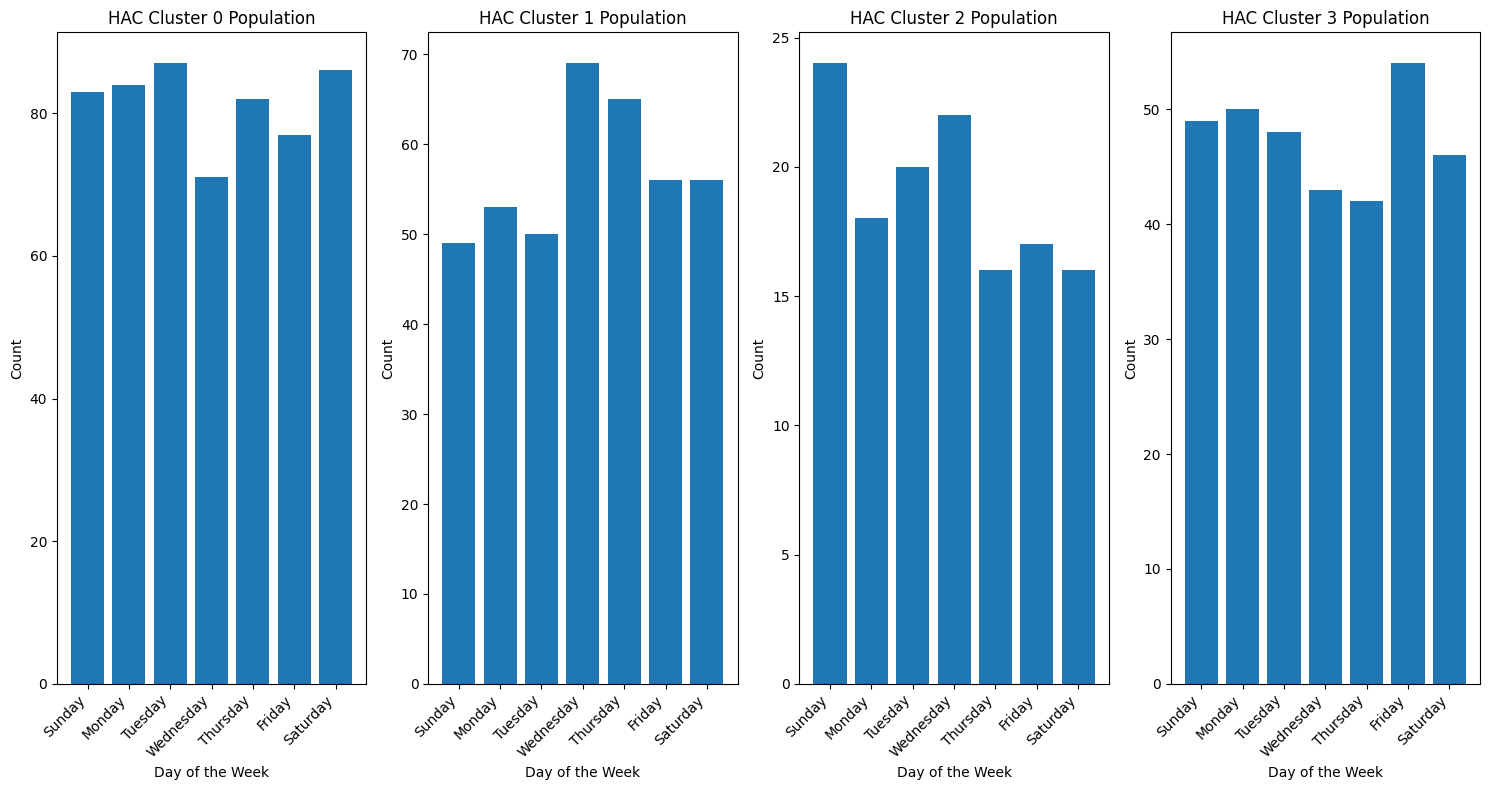

In [75]:
data = X_pca
n_clusters = 4

# Perform Hierarchical Agglomerative Clustering
hac = AgglomerativeClustering(n_clusters=n_clusters, linkage='ward')
hac_labels = hac.fit_predict(data)


data_ = data

tsne = TSNE(n_components=3, init='pca', random_state=0)
X_tsne = tsne.fit_transform(data_)

# Create a DataFrame for Plotly
tsne_df = pd.DataFrame(X_tsne, columns=['Dimension 1', 'Dimension 2', 'Dimension 3'])
tsne_df['Cluster'] = hac_labels.astype(str)

# Create 3D scatter plot
fig = px.scatter_3d(tsne_df, x='Dimension 1', y='Dimension 2', z='Dimension 3',
                    color='Cluster', title=f'3D t-SNE visualization of HAC clusters (n_clusters={n_clusters})', size_max=3)
fig.show()

# Analyze cluster populations by day of the week
day_label = ['Sunday', 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday']
hac_population = np.zeros((n_clusters, 7))
for i in range(data.shape[0]):
    hac_population[hac_labels[i], i % 7] += 1

hac_population_df = pd.DataFrame(hac_population, columns=day_label)

print("\nHAC Cluster Population Distribution:")
display(hac_population_df)

# Plot the population distribution
plt.figure(figsize=(15, max(5, n_clusters * 2)))
for i in range(hac_population_df.shape[0]):
    plt.subplot(max(1, (n_clusters + 3) // 4), 4, i + 1)
    plt.bar(hac_population_df.columns, hac_population_df.iloc[i, :])
    plt.title(f'HAC Cluster {i} Population')
    plt.xlabel('Day of the Week')
    plt.ylabel('Count')
    plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

###plot original features' mean per cluster

In [76]:
# Group the original data by day and calculate the mean for each day
X_daily_mean = X_scaled.groupby('Date')[numeric_cols].mean().reset_index()

# Add cluster labels to the daily mean dataframe
X_daily_mean['KMeans_Cluster'] = kmeans_labels
X_daily_mean['HAC_Cluster'] = hac_labels

# Calculate and display mean values per cluster for K-Means
print("K-Means Cluster Mean Original Feature Values:")
kmeans_mean_original_features = X_daily_mean.groupby('KMeans_Cluster')[numeric_cols].mean()
display(kmeans_mean_original_features)

# Calculate and display mean values per cluster for HAC
print("\nHAC Cluster Mean Original Feature Values:")
hac_mean_original_features = X_daily_mean.groupby('HAC_Cluster')[numeric_cols].mean()
display(hac_mean_original_features)

# Reshape the data for plotting
kmeans_plot_data = kmeans_mean_original_features.reset_index().melt('KMeans_Cluster', var_name='Feature', value_name='Mean Value')
hac_plot_data = hac_mean_original_features.reset_index().melt('HAC_Cluster', var_name='Feature', value_name='Mean Value')

# Plot the mean original feature values for each K-Means cluster as a grouped bar plot
fig_kmeans_bar = px.bar(kmeans_plot_data, x='KMeans_Cluster', y='Mean Value', color='Feature',
                        barmode='group', title='Mean Value of Original Features per K-Means Cluster',
                        labels={'KMeans_Cluster': 'Cluster'})
fig_kmeans_bar.update_layout(xaxis = dict(tickmode = 'linear', tick0 = 0, dtick = 1))
fig_kmeans_bar.show()

# Plot the mean original feature values for each HAC cluster as a grouped bar plot
fig_hac_bar = px.bar(hac_plot_data, x='HAC_Cluster', y='Mean Value', color='Feature',
                     barmode='group', title='Mean Value of Original Features per HAC Cluster',
                     labels={'HAC_Cluster': 'Cluster'})
fig_hac_bar.update_layout(xaxis = dict(tickmode = 'linear', tick0 = 0, dtick = 1))
fig_hac_bar.show()

K-Means Cluster Mean Original Feature Values:


,Global_active_power,Global_reactive_power,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
KMeans_Cluster,,,,,,
0,0.084694,0.081343,0.084622,0.008144,0.007409,0.214337
1,0.091378,0.092410,0.091369,0.014931,0.009107,0.218685
2,0.127505,0.095713,0.126059,0.021754,0.039147,0.245408
3,0.037977,0.086398,0.040506,0.000542,0.005632,0.092877



HAC Cluster Mean Original Feature Values:


,Global_active_power,Global_reactive_power,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
HAC_Cluster,,,,,,
0,0.112369,0.091374,0.111604,0.017069,0.032582,0.227802
1,0.091464,0.094836,0.091401,0.015804,0.006480,0.219301
2,0.031024,0.085310,0.033781,0.000092,0.005038,0.077124
3,0.082026,0.079734,0.081965,0.006800,0.004340,0.212342
